In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Parameters
ticker = "AAPL"
period = "2y"
interval = "1d"
data_path = "../data/aapl.csv"

In [3]:
# Download Data
if not os.path.exists(data_path):
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, period=period, interval=interval)
    
    if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
    print("Data downloaded successfully.")
else:
    print(f"Data for {ticker} already exists at {data_path}. Loading from file.")
    data = pd.read_csv(data_path, index_col='Date', parse_dates=True)

Data for AAPL already exists at ../data/aapl.csv. Loading from file.


In [4]:
# Create Lagged Returns
data['Returns'] = data['Close'].pct_change()

# creates lagged returns for specified lags
lags  = [1,2,3,5]
for lag in lags:
    data[f'Lagged_Returns_{lag}'] = data['Returns'].shift(lag)

In [5]:
# Create Moving Averages
MA_periods = [5, 20, 100]
for period in MA_periods:
    data[f"MA_{period}"] = data['Close'].rolling(window = period).mean()

In [6]:
# Create RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

In [7]:
# Create MACD
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['Signal_Line']

In [8]:
# Create Bollinger Bands 
sma_20 = data['Close'].rolling(window=20).mean()
upper_band = sma_20 + 2 * data['Close'].rolling(window=20).std()
lower_band = sma_20 - 2 * data['Close'].rolling(window=20).std()
data['Upper_Band'] = upper_band
data['Lower_Band'] = lower_band

In [9]:
# Create Volatility
vol_windows = [10, 20, 60]
for window in vol_windows:
    data[f'Volatility_{window}'] = data['Close'].rolling(window=window).std()

In [10]:
# Create Target Variable
data['Target_Classification'] = (data['Returns'].shift(-1) > 0).astype(int)
data['Target_Regression'] = data['Returns'].shift(-1) 

In [11]:
# Save to CSV
data.to_csv(data_path)
print(f"Data saved to {data_path}")

Data saved to ../data/aapl.csv


In [12]:
# # Create X and Y
x_unclean = data[['Lagged_Returns_1', 'Lagged_Returns_2', 'Lagged_Returns_3', 'Lagged_Returns_5',
              'MA_5', 'MA_20', 'RSI', 'MACD', 'Signal_Line', 'MACD_Hist',
              'Upper_Band', 'Lower_Band', 'Volatility_10', 'Volatility_20']]
y_unclean_classification = data['Target_Classification']
y_unclean_regression = data['Target_Regression']

combined_classification = pd.concat([x_unclean, y_unclean_classification.rename('Target')], axis=1).dropna()
combined_regression = pd.concat([x_unclean, y_unclean_regression.rename('Target')], axis=1).dropna()

x_clean = combined_classification.drop(columns=['Target'],axis=1)
y_clean_classification = combined_classification['Target']
y_clean_regression = combined_regression['Target']

In [13]:
# Split Data into Train and Test Sets
cutoff_date = "2024-07-01"

x_train, x_test, y_train_class, y_test_class = train_test_split(
    x_clean, y_clean_classification, test_size=0.2, shuffle=False
)

# x_train = x_clean.loc[:cutoff_date]
# x_test = x_clean.loc[cutoff_date:]

# # Classification

# y_train_class = y_clean_classification.loc[:cutoff_date]
# y_test_class = y_clean_classification.loc[cutoff_date:]

# # Regression
# y_train_reg = y_clean_regression.loc[:cutoff_date]
# y_test_reg = y_clean_regression.loc[cutoff_date:]

In [14]:
# Baseline Model: Logistic Regression
model = LogisticRegression(max_iter=1000)
scaler = StandardScaler()
x_train_class = scaler.fit_transform(x_train)
x_test_class = scaler.transform(x_test)
model.fit(x_train_class, y_train_class)
predictions = model.predict(x_test_class)
accuracy = accuracy_score(y_test_class, predictions)
conf_matrix = confusion_matrix(y_test_class, predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print(y_train_class.value_counts(normalize=True))

Accuracy: 0.5463917525773195
Confusion Matrix:
 [[ 8 36]
 [ 8 45]]
Target
1    0.558442
0    0.441558
Name: proportion, dtype: float64


In [15]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train_class)

y_pred = rf_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test_class, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred))

Accuracy: 0.6288659793814433
Confusion Matrix:
 [[16 28]
 [ 8 45]]


In [ ]:
# XGBoost Classifier

xbg_model = XGBClassifier()
xbg_model.fit(x_train, y_train_class)

y_pred_xbg = xbg_model.predict(x_test)

print("XGBoost Accuracy:", accuracy_score(y_test_class, y_pred_xbg))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_xbg))

XGBoost Accuracy: 0.5773195876288659
XGBoost Confusion Matrix:
 [[16 28]
 [13 40]]


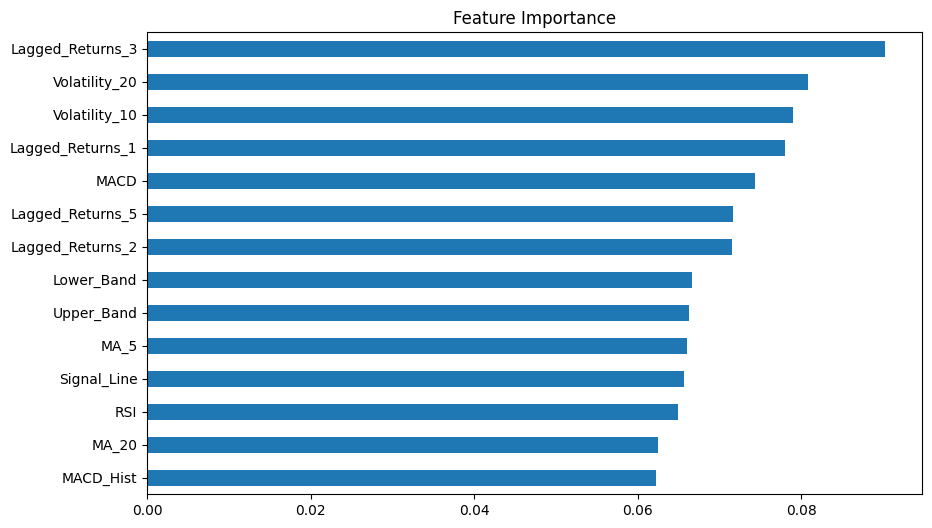

In [17]:
# Show feature importance
importances = pd.Series(rf_model.feature_importances_, index=x_clean.columns)
importances.sort_values().plot(kind="barh", figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [18]:
# Basic Exploration
print(data.head())

                 Close        High         Low        Open    Volume  \
Date                                                                   
2023-07-24  190.839279  192.977871  190.344236  191.492740  45377800   
2023-07-25  191.700638  192.512516  191.007580  191.413519  37283200   
2023-07-26  192.571915  193.700613  191.403619  191.750141  47471900   
2023-07-27  191.304581  195.245122  190.641224  194.076827  47460200   
2023-07-28  193.888733  194.680806  192.215484  192.740228  48291400   

             Returns  Lagged_Returns_1  Lagged_Returns_2  Lagged_Returns_3  \
Date                                                                         
2023-07-24       NaN               NaN               NaN               NaN   
2023-07-25  0.004514               NaN               NaN               NaN   
2023-07-26  0.004545          0.004514               NaN               NaN   
2023-07-27 -0.006581          0.004545          0.004514               NaN   
2023-07-28  0.013508       

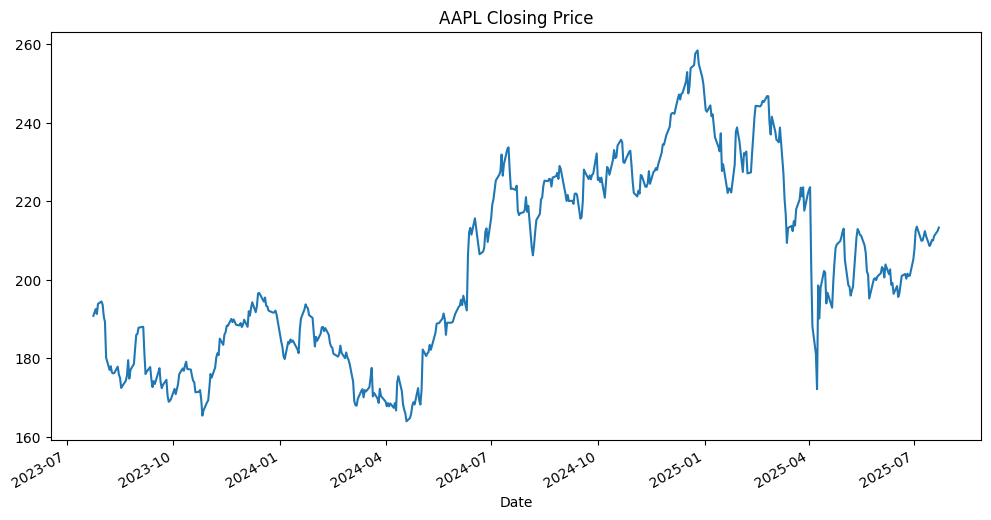

In [19]:
# Plot Close price
plt.figure(figsize=(12,6))
data['Close'].plot(title=f"{ticker} Closing Price")
plt.show()

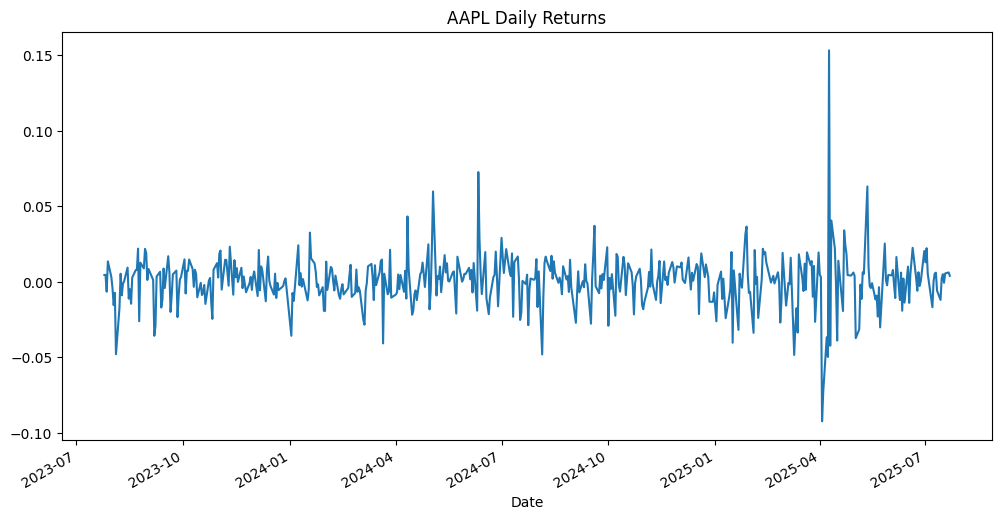

In [20]:
# Calculate daily returns and plot
data['Returns'] = data['Close'].pct_change()
plt.figure(figsize=(12,6))
data['Returns'].plot(title=f"{ticker} Daily Returns")
plt.show()

In [21]:
# Check for missing data
missing = data.isnull().sum()
print("Missing data per column:\n", missing)

Missing data per column:
 Close                     0
High                      0
Low                       0
Open                      0
Volume                    0
Returns                   1
Lagged_Returns_1          2
Lagged_Returns_2          3
Lagged_Returns_3          4
Lagged_Returns_5          6
MA_5                      4
MA_20                    19
MA_100                   99
RSI                      13
MACD                      0
Signal_Line               0
MACD_Hist                 0
Upper_Band               19
Lower_Band               19
Volatility_10             9
Volatility_20            19
Volatility_60            59
Target_Classification     0
Target_Regression         1
dtype: int64
